In [1]:
# importing the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# split data train and test
train = pd.read_csv("data/train_v9rqX0R.csv")
test = pd.read_csv("data/test_AbJTz2l.csv")

In [3]:
#combined data for feature engineering for both train and test data

test['Item_Outlet_Sales'] = np.nan

data = pd.concat([train, test], sort=False, ignore_index=True)

data.shape


(14204, 12)

# FE 1 : Missing Data Treatment

In [4]:
# Analyze missing values from last EDA we got
missing_counts = data.isnull().sum().sort_values(ascending=False)
missing_data = missing_counts[missing_counts > 0]
missing_data

Item_Outlet_Sales    5681
Outlet_Size          4016
Item_Weight          2439
dtype: int64

In [5]:

missing_percent = (missing_data / len(data)) * 100
missing_percent


Item_Outlet_Sales    39.995776
Outlet_Size          28.273726
Item_Weight          17.171219
dtype: float64

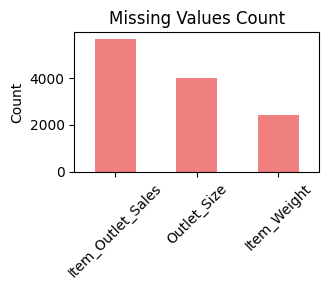

In [6]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
missing_cols = missing_data[missing_data > 0]
if len(missing_cols) > 0:
    missing_cols.plot(kind='bar', color='lightcoral')
    plt.title('Missing Values Count')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

  ### Observation
  1) Item_Outlet_Sales: 5681 (40.00%)
  2) Outlet_Size: 4016 (28.27%)
  3) Item_Weight: 2439 (17.17%)

# FE2 : Categorical Feature Standardization

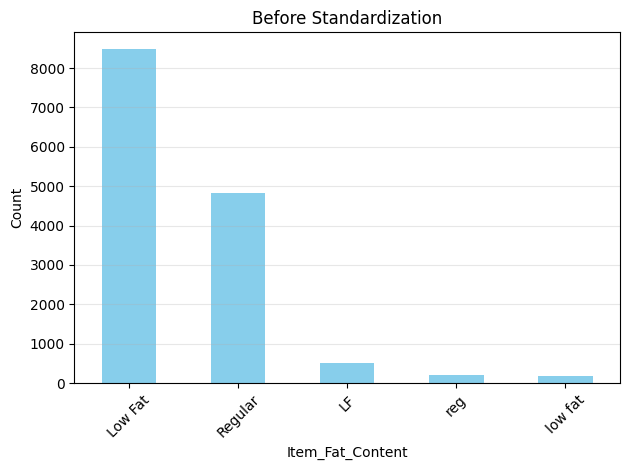

In [7]:
data['Item_Fat_Content'].value_counts().plot(kind='bar', color='skyblue', title='Before Standardization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Standardize Item_Fat_Content on LF = Low Fat, reg = Regular, low fat = Low Fat
fat_content_mapping = {
    'LF': 'Low Fat',
    'low fat': 'Low Fat', 
    'reg': 'Regular'
}

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace(fat_content_mapping)

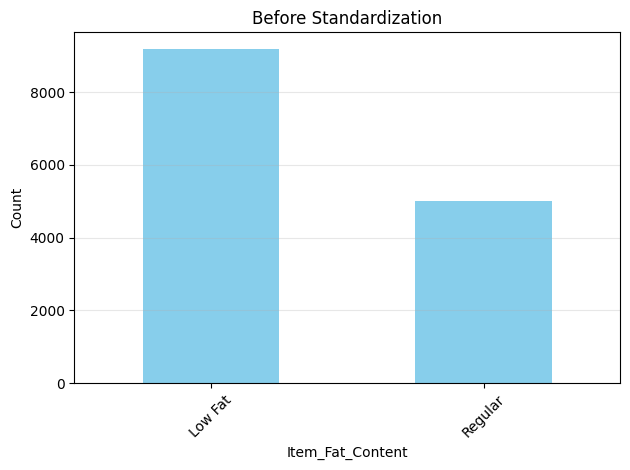

In [9]:
data['Item_Fat_Content'].value_counts().plot(kind='bar', color='skyblue', title='Before Standardization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# FE3 : Feature Creation

In [10]:
# Before category mapping
data['Item_Identifier'].value_counts()

Item_Identifier
FDU15    10
FDS25    10
FDA38    10
FDW03    10
FDJ10    10
         ..
FDR51     7
FDM52     7
DRN11     7
FDH58     7
NCW54     7
Name: count, Length: 1559, dtype: int64

In [11]:
# Category mapping based on business rule on category identification
category_map = {'F': 'Food', 'D': 'Drinks', 'N': 'Non-Consumable'}

# Create Item_Type_Combined directly
data['Item_Type_Combined'] = data['Item_Identifier'].str[0].str.upper().map(category_map)

In [12]:
# After category mapping
print(data['Item_Type_Combined'].value_counts())

Item_Type_Combined
Food              10201
Non-Consumable     2686
Drinks             1317
Name: count, dtype: int64


Text(0, 0.5, 'Count')

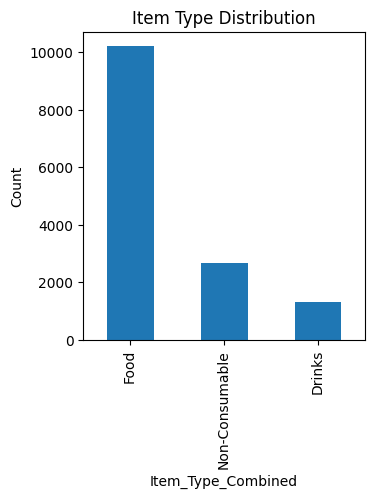

In [13]:

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
data['Item_Type_Combined'].value_counts().plot(kind='bar')
plt.title('Item Type Distribution')
plt.ylabel('Count')


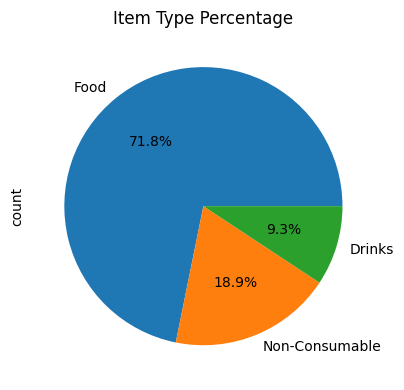

In [14]:
# Pie chart
plt.figure(figsize=(8, 4))
data['Item_Type_Combined'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Item Type Percentage')

plt.tight_layout()
plt.show()

In [15]:
# Before updating: Non-consumable items with fat content
data[data['Item_Type_Combined'] == 'Non-Consumable']['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    2686
Name: count, dtype: int64

In [16]:
# Business Logic  non consumable items and high fat content is not good
data.loc[data['Item_Type_Combined'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'


In [17]:
# After updating: Non-consumable items with fat content
data[data['Item_Type_Combined'] == 'Non-Consumable']['Item_Fat_Content'].value_counts()


Item_Fat_Content
Non-Edible    2686
Name: count, dtype: int64

# FE5 : Missing Value Imputation

In [18]:
# 5.1 Item_Weight Imputation
print("5.1 Imputing Item_Weight using group statistics...")
print(f"Missing Item_Weight values: {data['Item_Weight'].isnull().sum()}")


5.1 Imputing Item_Weight using group statistics...
Missing Item_Weight values: 2439


In [19]:

# Business Logic: Items of same type should have similar weights
weight_by_type = data.groupby('Item_Type_Combined')['Item_Weight'].agg(['mean', 'median', 'std'])
print("\nWeight statistics by Item_Type_Combined:")
print(weight_by_type)



Weight statistics by Item_Type_Combined:
                         mean  median       std
Item_Type_Combined                             
Drinks              12.116645    11.8  4.450654
Food                12.735577    12.5  4.633457
Non-Consumable      13.344139    13.0  4.764598


In [20]:

# Impute using group mean
data['Item_Weight'] = data['Item_Weight'].fillna(
    data.groupby('Item_Type_Combined')['Item_Weight'].transform('mean')
)

print(f"Remaining missing Item_Weight values: {data['Item_Weight'].isnull().sum()}")


Remaining missing Item_Weight values: 0


In [21]:

# 5.2 Item_Visibility Imputation
print("\n5.2 Handling Item_Visibility...")
print(f"Zero visibility items: {(data['Item_Visibility'] == 0).sum()}")

# Business Logic: Zero visibility is likely missing data, not actual zero
# Create flag for zero visibility before imputation
data['Zero_Visibility_Flag'] = (data['Item_Visibility'] == 0).astype(int)

# Replace zero with NaN for proper imputation
data['Item_Visibility'] = data['Item_Visibility'].replace(0, np.nan)
print(f"Items with zero/missing visibility: {data['Item_Visibility'].isnull().sum()}")

# Impute using median within Item_Type_Combined and Outlet_Type groups
# Business Logic: Similar items in similar outlet types should have similar visibility
data['Item_Visibility'] = data['Item_Visibility'].fillna(
    data.groupby(['Item_Type_Combined', 'Outlet_Type'])['Item_Visibility'].transform('median')
)

print(f"Remaining missing Item_Visibility values: {data['Item_Visibility'].isnull().sum()}")



5.2 Handling Item_Visibility...
Zero visibility items: 879
Items with zero/missing visibility: 879
Remaining missing Item_Visibility values: 0


In [22]:

# 5.3 Outlet_Size Imputation
print("\n5.3 Imputing Outlet_Size...")
print(f"Missing Outlet_Size values: {data['Outlet_Size'].isnull().sum()}")

# Business Logic: Outlet size depends on outlet type and location
outlet_size_mode = data.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Medium')
print("\nOutlet_Size mode by Outlet_Type and Location:")
print(outlet_size_mode)

def fill_outlet_size(row):
    """Fill missing outlet size based on type and location"""
    if pd.isna(row['Outlet_Size']):
        mode_data = data[(data['Outlet_Type'] == row['Outlet_Type']) & 
                        (data['Outlet_Location_Type'] == row['Outlet_Location_Type'])]['Outlet_Size'].mode()
        return mode_data.iloc[0] if not mode_data.empty else 'Medium'
    return row['Outlet_Size']

data['Outlet_Size'] = data.apply(fill_outlet_size, axis=1)
print(f"Remaining missing Outlet_Size values: {data['Outlet_Size'].isnull().sum()}")



5.3 Imputing Outlet_Size...
Missing Outlet_Size values: 4016

Outlet_Size mode by Outlet_Type and Location:
Outlet_Type        Outlet_Location_Type
Grocery Store      Tier 1                   Small
                   Tier 3                  Medium
Supermarket Type1  Tier 1                  Medium
                   Tier 2                   Small
                   Tier 3                    High
Supermarket Type2  Tier 3                  Medium
Supermarket Type3  Tier 3                  Medium
Name: Outlet_Size, dtype: object
Remaining missing Outlet_Size values: 0


count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64


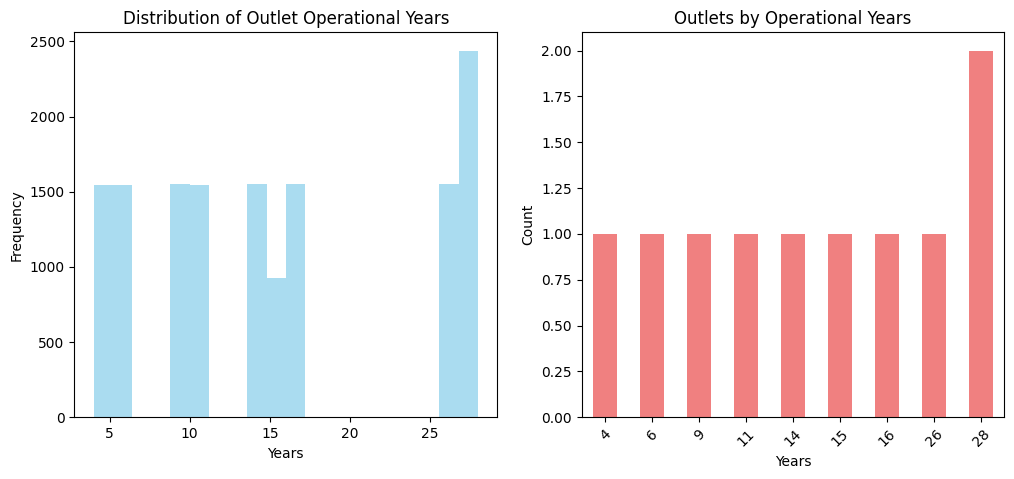

In [23]:
# Calculate outlet operational years
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
print(data['Outlet_Years'].describe())

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

data['Outlet_Years'].plot.hist(bins=20, color='skyblue', alpha=0.7, ax=ax[0])
ax[0].set(title='Distribution of Outlet Operational Years', xlabel='Years', ylabel='Frequency')

data.groupby('Outlet_Years')['Outlet_Identifier'].nunique().plot.bar(color='lightcoral', ax=ax[1])
ax[1].set(title='Outlets by Operational Years', xlabel='Years', ylabel='Count')
ax[1].tick_params(axis='x', rotation=45)

plt.show()


# FE 7 : Log transform skewed feature

Item_Weight skewness: 0.111
Item_Visibility skewness: 1.330
Item_MRP skewness: 0.131


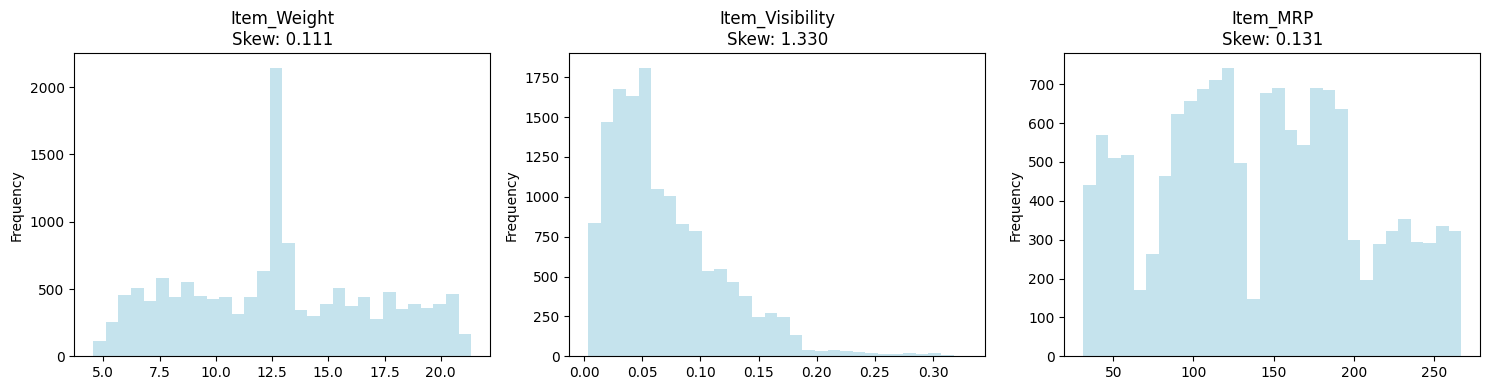

In [24]:
from scipy.stats import skew

numerical_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(numerical_features):
    vals = data[feature].dropna()
    skew_val = skew(vals)
    print(f"{feature} skewness: {skew_val:.3f}")
    
    axes[i].hist(vals, bins=30, color='lightblue', alpha=0.7)
    axes[i].set_title(f'{feature}\nSkew: {skew_val:.3f}')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [25]:
# Apply log transformations
data['Item_Weight_log'] = np.log1p(data['Item_Weight'])
data['Item_Visibility_log'] = np.log1p(data['Item_Visibility'])
data['Item_MRP_log'] = np.log1p(data['Item_MRP'])


Item_Weight_log skewness: -0.452
Item_Visibility_log skewness: 1.173
Item_MRP_log skewness: -0.721


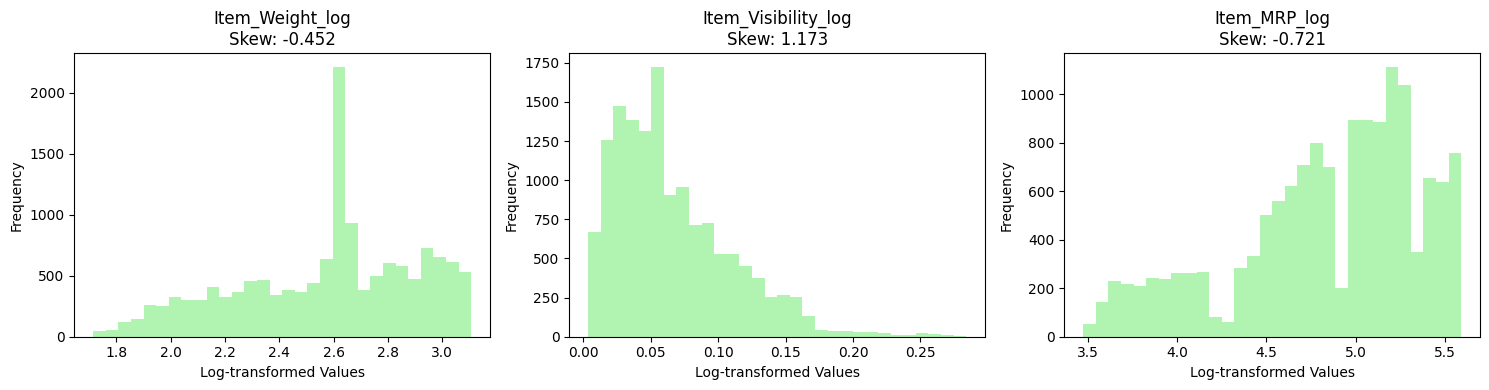

In [26]:
# Check skewness after log transformation application
log_features = ['Item_Weight_log', 'Item_Visibility_log', 'Item_MRP_log']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(log_features):
    vals = data[feature].dropna()
    skew_val = skew(vals)
    print(f"{feature} skewness: {skew_val:.3f}")

    axes[i].hist(vals, bins=30, color='lightgreen', alpha=0.7)
    axes[i].set_title(f'{feature}\nSkew: {skew_val:.3f}')
    axes[i].set_xlabel('Log-transformed Values')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# FE8 : Creating Item visibility ration agasinst Iten_identification and outlet type

In [27]:
# Create Item_Visibility_MeanRatio
data['Item_Visibility_MeanRatio'] = data['Item_Visibility'] / (
    data.groupby(['Item_Identifier', 'Outlet_Type'])['Item_Visibility'].transform('mean') + 1e-8
)

print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.000000
std          0.163886
min          0.276375
25%          0.998443
50%          1.000000
75%          1.000657
max          4.101195
Name: Item_Visibility_MeanRatio, dtype: float64


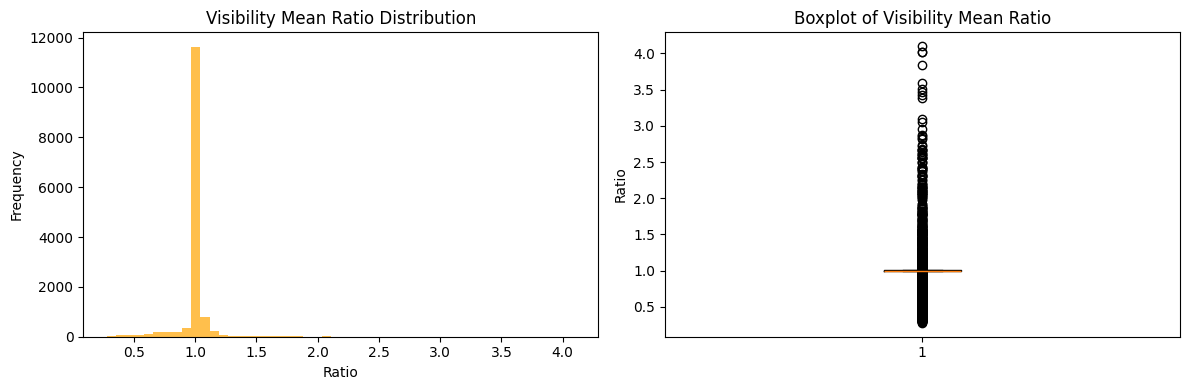

In [28]:
# Check distribution and outlier using boxplot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data['Item_Visibility_MeanRatio'].plot.hist(bins=50, color='orange', alpha=0.7, ax=ax[0])
ax[0].set(title='Visibility Mean Ratio Distribution', xlabel='Ratio', ylabel='Frequency')

ax[1].boxplot(data['Item_Visibility_MeanRatio'].dropna())
ax[1].set(title='Boxplot of Visibility Mean Ratio', ylabel='Ratio')

plt.tight_layout()
plt.show()


# FE 9 : Create Interaction feature for more depth to understand 2 feature corelation

In [29]:
# Create interaction features
data['MRP_Outlet_Years'] = data['Item_MRP'] * data['Outlet_Years']
data['MRP_Visibility']   = data['Item_MRP'] * data['Item_Visibility']
data['MRP_Weight']       = data['Item_MRP'] * data['Item_Weight']
data['Weight_Visibility'] = data['Item_Weight'] * data['Item_Visibility']

interaction_features = ['MRP_Outlet_Years', 'MRP_Visibility', 'MRP_Weight', 'Weight_Visibility']

In [30]:
print(data[interaction_features].describe().T)

                     count         mean          std         min         25%  \
MRP_Outlet_Years   14204.0  2138.875931  1595.989689  127.560000  912.062450   
MRP_Visibility     14204.0     9.787505     8.587333    0.276042    3.717784   
MRP_Weight         14204.0  1812.647799  1043.870266  172.262295  958.438454   
Weight_Visibility  14204.0     0.886952     0.706411    0.021104    0.380392   

                           50%          75%          max  
MRP_Outlet_Years   1671.963200  2916.985200  7464.475200  
MRP_Visibility        7.172411    13.362021    82.347549  
MRP_Weight         1619.713274  2448.387618  5575.078530  
Weight_Visibility     0.690092     1.183709     5.883448  


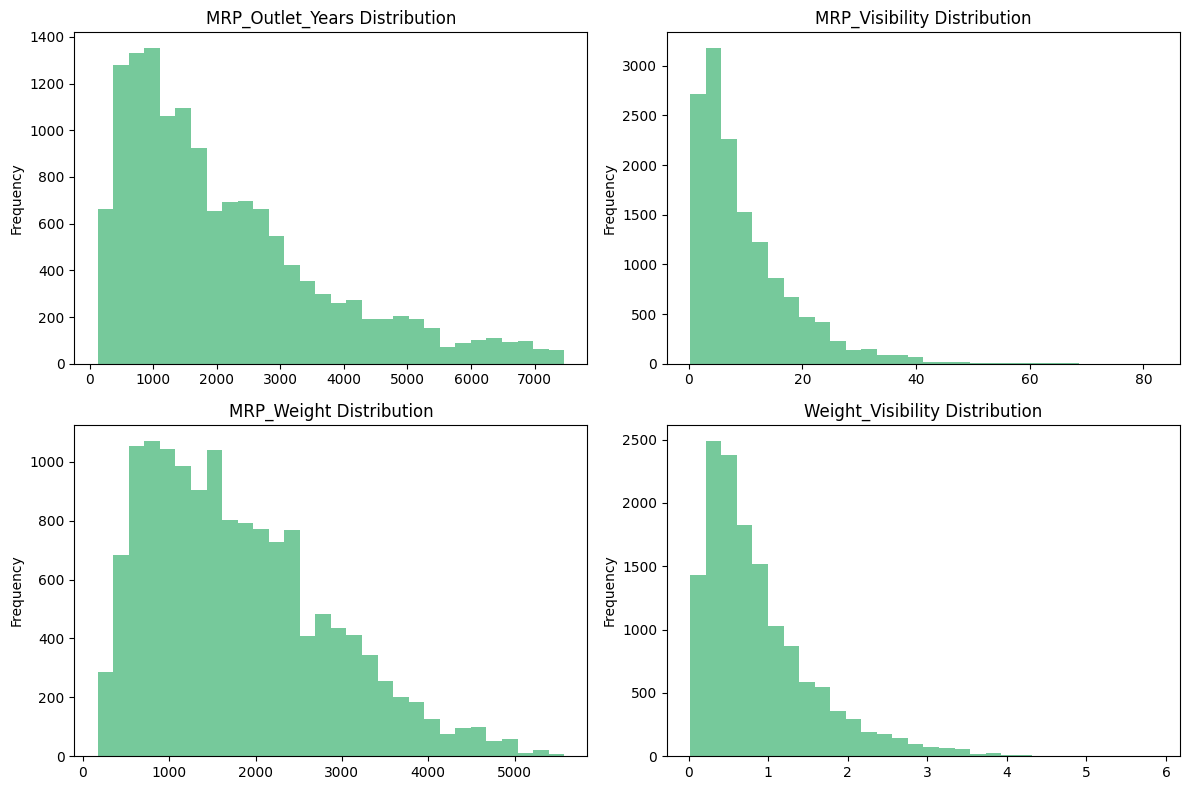

In [31]:
# Visualize The Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feature in zip(axes.ravel(), interaction_features):
    ax.hist(data[feature].dropna(), bins=30, color='mediumseagreen', alpha=0.7)
    ax.set_title(f'{feature} Distribution')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### After this feature enginnering we will combine evrything into single ML Modelling pipeline and arrive at final solution using ML technique.